In [1]:
# import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import rc
from scipy.signal import find_peaks 
from cProfile import label
from scipy.integrate import quad

In [2]:
uvvis_path = "MnSpecies_uvvis.CSV"
uvvis=pd.read_csv(uvvis_path, sep = ';', decimal = ',')

peak_path = "MnSpecies_peak.CSV"
peak=pd.read_csv(peak_path, sep = ';', decimal = ',')

uvvis_water_path = "MnSpecies_water_uvvis.CSV"
uvvis_water=pd.read_csv(uvvis_water_path, sep = ';', decimal = ',')

peak_water_path = "MnSpecies_water_peak.CSV"
peak_water=pd.read_csv(peak_water_path, sep = ';', decimal = ',')

MnCl2aq_uvvis_path = "functional_uvvis.CSV"
MnCl2aq_uvvis=pd.read_csv(MnCl2aq_uvvis_path, sep = ';', decimal = ',')

MnCl2aq_peak_path = "functional_peak.CSV"
MnCl2aq_peak=pd.read_csv(MnCl2aq_peak_path, sep = ';', decimal = ',')

MnCl2aq_uvvis_water_path = "functional_uvvis_water.CSV"
MnCl2aq_uvvis_water=pd.read_csv(MnCl2aq_uvvis_water_path, sep = ';', decimal = ',')

MnCl2aq_peak_water_path = "functional_peak_water.CSV"
MnCl2aq_peak_water=pd.read_csv(MnCl2aq_peak_water_path, sep = ';', decimal = ',')

In [3]:
in_water_path = "cross_sec_MnCl2Short.csv"
in_water=pd.read_csv(in_water_path, index_col=0)

in_hcl_path = "cross_sec_inHClShort.csv"
in_hcl=pd.read_csv(in_hcl_path, index_col=0)

ForRep_path = "cross_sec_ForRepShort.csv"
ForRep=pd.read_csv(ForRep_path, index_col=0)

wNaCl_path = "cross_sec_wNaCl.csv"
wNaCl=pd.read_csv(wNaCl_path, index_col=0)

solar_path = 'solar_spectral_irradiance.CSV'
solar_irradiance = pd.read_csv(solar_path, sep = ';', decimal = ',')

no2_path = 'no2_rate.CSV'
no2_rate = pd.read_csv(no2_path, sep = ';', decimal = ',', index_col = 0)

In [4]:
c_inWater = [3.47632762, 1.77252286, 0.87918751, 0.41887727, 0.23091304, 0.10358244, 0.05962306, 0.02526401]
c_inHCl = [3.08018796, 1.66742459, 0.83068061, 0.43100399, 0.22030216, 0.11570916, 0.05760194]
c_ForRep = [1.62285888e+00, 1.63094336e+00, 8.93486939e-01, 8.75953716e-01, 4.69910565e-04, 5.15385781e-04]

In [5]:
def cross_section(epsilon):
    sigma = (1000*epsilon)/(6.022*10**23) #epsilon is in L/mol*cm so the multiplication by 1000 is conversion from L to cm**3
    return sigma

def makesigma(xvalues, yvalues):
    sigma = cross_section(yvalues.to_numpy())
    index = xvalues.to_numpy()
    return pd.DataFrame(sigma, index = index)

def photolysisrate(F1, sigma, lamb, c):
    F2 = F1*((lamb)/((6.626*10**(-34))*(3*10**(8))))*10**(-13)
    # print(F2)
    delta_lambda = np.append(lamb[1:]-lamb[0:-1], np.array([10]))
    j = F2*sigma*delta_lambda # quantum yield assumed 1
    j_total = np.sum(j)
    k = (j/c)
    return j, j_total, k

def photolysisrate_cal(sigma, solar):
    wavelength_extension = np.linspace(max(sigma.index)+0.1, 630, 1000)
    sigma_extension = pd.DataFrame(np.zeros_like(wavelength_extension), index = wavelength_extension)
    sigmacom = pd.concat([sigma, sigma_extension])
    sigmaoi = sigmacom.iloc[sigmacom.index.get_indexer(solar["wavelength"].to_numpy(), method="nearest")]

    F1 = solar[solar.keys()[1]].to_numpy()
    lamb = solar[solar.keys()[0]].to_numpy()
    sigmav = sigmaoi.to_numpy().flatten()
    F2 = F1*((lamb)/((6.626*10**(-34))*(3*10**(8))))*10**(-13)
    delta_lambda = np.append(lamb[1:]-lamb[0:-1], np.array([10]))
    j = F2*sigmav*delta_lambda
    return pd.DataFrame(j.T, index = lamb, columns = ["j"])

In [6]:
sigma_MnCl2wH2O = makesigma(MnCl2aq_uvvis["X b3lyp6311++"], MnCl2aq_uvvis['Y b3lyp6311++'])
sigma_MnCl = makesigma(uvvis['X MnCl+'], uvvis['Y MnCl+'])
sigma_MnCl3 = makesigma(uvvis['X MnCl3-'], uvvis['Y MnCl3-'])
sigma_MnClH2O = makesigma(uvvis['X MnClH2O'], uvvis['Y MnClH2O'])
sigma_MnH2O = makesigma(uvvis['X MnH2O'], uvvis['Y MnH2O'])
sigma_MnCl2 = makesigma(uvvis['X MnCl2'], uvvis['Y MnCl2'])

sigma_MnCl2wH2O_water = makesigma(MnCl2aq_uvvis_water['X b3lyp6311++'], MnCl2aq_uvvis_water['Y b3lyp6311++'])
sigma_MnCl_water = makesigma(uvvis_water['X MnCl+'], uvvis_water['Y MnCl+'])
sigma_MnCl3_water = makesigma(uvvis_water['X MnCl3-'], uvvis_water['Y MnCl3-'])
sigma_MnClH2O_water = makesigma(uvvis_water['X MnClH2O'], uvvis_water['Y MnClH2O'])
sigma_MnH2O_water = makesigma(uvvis_water['X MnH2O'], uvvis_water['Y MnH2O'])
sigma_MnCl2_water = makesigma(uvvis_water['X MnCl2'], uvvis_water['Y MnCl2'])

In [7]:

voi = ForRep.loc[solar_irradiance["wavelength"].to_numpy(), :]
jvalues1, j1_total, k1 = photolysisrate(solar_irradiance["F(lambda)"].to_numpy(), voi["s1.3"].to_numpy(), solar_irradiance["wavelength"].to_numpy(), c_ForRep[0]) # s1.3
jvalues2, j2_total, k2 = photolysisrate(solar_irradiance["F(lambda)"].to_numpy(), voi["s2.3"].to_numpy(), solar_irradiance["wavelength"].to_numpy(), c_ForRep[1]) # s2.3
jvalues3, j3_total, k3 = photolysisrate(solar_irradiance["F(lambda)"].to_numpy(), voi["s3.3"].to_numpy(), solar_irradiance["wavelength"].to_numpy(), c_ForRep[2]) # s3.3
jvalues4, j4_total, k4 = photolysisrate(solar_irradiance["F(lambda)"].to_numpy(), voi["s4.3"].to_numpy(), solar_irradiance["wavelength"].to_numpy(), c_ForRep[3]) # s4.3

j1 = pd.DataFrame(jvalues1.T, index = solar_irradiance["wavelength"], columns = ["j"])
j2 = pd.DataFrame(jvalues2.T, index = solar_irradiance["wavelength"], columns = ["j"])

print(j1_total, j2_total)
# display(j1)

2.8099374885957924e-06 3.1959994850603457e-06


In [8]:
jMnCl = photolysisrate_cal(sigma_MnCl, solar_irradiance)
jMnCl2wH2O = photolysisrate_cal(sigma_MnCl2wH2O, solar_irradiance)
jMnCl3 = photolysisrate_cal(sigma_MnCl3, solar_irradiance)
jMnClH2O = photolysisrate_cal(sigma_MnClH2O, solar_irradiance)
jMnH2O = photolysisrate_cal(sigma_MnH2O, solar_irradiance)
jMnCl2 = photolysisrate_cal(sigma_MnCl2, solar_irradiance)

jMnCl_water = photolysisrate_cal(sigma_MnCl_water, solar_irradiance)
jMnCl2wH2O_water = photolysisrate_cal(sigma_MnCl2wH2O_water, solar_irradiance)
jMnCl3_water = photolysisrate_cal(sigma_MnCl3_water, solar_irradiance)
jMnClH2O_water = photolysisrate_cal(sigma_MnClH2O_water, solar_irradiance)
jMnH2O_water = photolysisrate_cal(sigma_MnH2O_water, solar_irradiance)
jMnCl2_water = photolysisrate_cal(sigma_MnCl2_water, solar_irradiance)

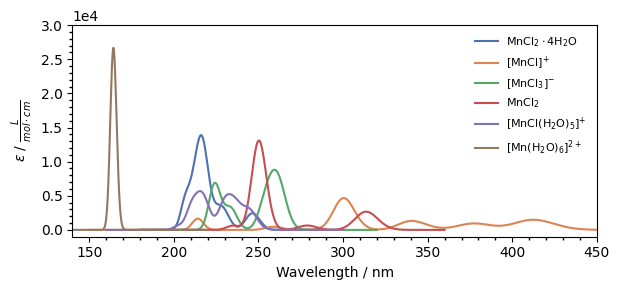

In [25]:
plt.figure(figsize=(6.3,3))
sns.set_palette("deep")
ax = sns.lineplot(data = MnCl2aq_uvvis, x = 'X b3lyp6311++', y = 'Y b3lyp6311++', label = r'MnCl$_{2}\cdot4$H$_{2}$O') 
sns.lineplot(data = uvvis, x = 'X MnCl+', y = 'Y MnCl+', label = r'[MnCl]$^{+}$') 
sns.lineplot(data = uvvis, x = 'X MnCl3-', y = 'Y MnCl3-', label = r'[MnCl$_{3}$]$^{-}$') 
sns.lineplot(data = uvvis, x = 'X MnCl2', y = 'Y MnCl2', label = r'MnCl$_{2}$') 
sns.lineplot(data = uvvis, x = 'X MnClH2O', y = 'Y MnClH2O', label = r'[MnCl(H$_{2}$O)$_{5}$]$^{+}$') 
sns.lineplot(data = uvvis, x = 'X MnH2O', y = 'Y MnH2O', label = r'[Mn(H$_{2}$O)$_{6}$]$^{2+}$') 

ax.set_xlabel('Wavelength / nm')
ax.set_ylabel(r'$\epsilon$ / $\frac{L}{mol \cdot cm}$')
ax.set_ylim(-1000, 30000)
ax.set_xlim(140, 450)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True)
ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (4,4))

# handles, labels = ax.get_legend_handles_labels()
plt.legend(frameon = False, fontsize = 8)
# rcParams['legend.columnspacing']=1
plt.tight_layout()
plt.savefig('Vacuum_species_uvvis.png', dpi=150)
plt.show()

In [11]:
def convert_to_line(x, y):
    search = np.around(np.arange(min(x), max(x)+0.01, 0.01), 2)
    values = np.zeros_like(search)
    x, y = np.unique([x, y], axis = 1)
    for idx, xvalue in enumerate(search):
        if xvalue in x:
            try:
                values[idx] = y[x == xvalue]
            except ValueError:
                values[idx-1], values[idx]  = y[x == xvalue]
    return np.array([list(search), list(values)]).T

In [50]:
MnCl2aq_peak_mod = pd.DataFrame(convert_to_line(MnCl2aq_peak["X b3lyp6311++"][:],  MnCl2aq_peak["Y b3lyp6311++"][:]), columns = MnCl2aq_peak.keys()[6:8:1])
MnCl_peak_mod = pd.DataFrame(convert_to_line(peak["X MnCl+"][:],  peak["Y MnCl+"][:]), columns = peak.keys()[0:2:1])
MnCl3_peak_mod = pd.DataFrame(convert_to_line(peak["X MnCl3-"][:],  peak["Y MnCl3-"][:]), columns = peak.keys()[3:5:1])
MnClH2O_peak_mod = pd.DataFrame(convert_to_line(peak["X MnClH2O"][:],  peak["Y MnClH2O"][:]), columns = peak.keys()[6:8:1])
MnCl2_peak_mod = pd.DataFrame(convert_to_line(peak["X MnCl2"][:],  peak["Y MnCl2"][:]), columns = peak.keys()[9:11:1])
MnH2O_peak_mod = pd.DataFrame(convert_to_line(peak["X MnH2O"][:],  peak["Y MnH2O"][:]), columns = peak.keys()[12:14:1])

MnCl2aq_water_peak_mod = pd.DataFrame(convert_to_line(MnCl2aq_peak_water["X b3lyp6311++"][:],  MnCl2aq_peak_water["Y b3lyp6311++"][:]), columns = MnCl2aq_peak_water.keys()[3:5:1])
# display(peak_water[peak_water.keys()[0:3:2]])
MnCl_water_peak_mod = pd.DataFrame(convert_to_line(peak_water["X MnCl+"][:],  peak_water["Y MnCl+"][:]), columns = peak_water.keys()[0:2:1])

MnCl3_water_peak_mod = pd.DataFrame(convert_to_line(peak_water["X MnCl3-"][:],  peak_water["Y MnCl3-"][:]), columns = peak_water.keys()[3:5:1])
MnClH2O_water_peak_mod = pd.DataFrame(convert_to_line(peak_water["X MnClH2O"][:],  peak_water["Y MnClH2O"][:]), columns = peak_water.keys()[6:8:1])
MnCl2_water_peak_mod = pd.DataFrame(convert_to_line(peak_water["X MnCl2"][:],  peak_water["Y MnCl2"][:]), columns = peak_water.keys()[9:11:1])
MnH2O_water_peak_mod = pd.DataFrame(convert_to_line(peak_water["X MnH2O"][:],  peak_water["Y MnH2O"][:]), columns = peak_water.keys()[12:14:1])

In [47]:
def make_subplots(ax1, dataname_uv, xdataname_uv, ydataname_uv, displaylabel, dataname_peak, xdataname_peak, ydataname_peak, scilimit_eps, scilimit_osc, bbox2anchor):
    ax = ax1
    sns.lineplot(data = dataname_uv, x = xdataname_uv, y = ydataname_uv, ax=ax, label = displaylabel)
    ax2=ax.twinx()
    sns.lineplot(data = dataname_peak, x = xdataname_peak, y = ydataname_peak, ax=ax2, linewidth=0.5, color = 'grey')
    ax.set_ylabel(r'$\epsilon$ / $\frac{L}{mol \cdot cm}$')
    ax.set_xlabel(r'Wavelength / nm')
    ax2.set_ylabel(r'$f_{fi}$')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax2.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True, labelsize = 8)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)
    ax2.tick_params(axis = 'y', which = 'major', direction = 'out', right = True, labelsize = 8)
    # ax2.set_yticks(ax2.get_yticks(), fontsize = 8)
    ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = scilimit_eps)
    ax2.ticklabel_format(axis = 'y', style = 'sci', scilimits = scilimit_osc)
    ax.yaxis.offsetText.set_fontsize(8)
    ax2.yaxis.offsetText.set_fontsize(8)
    ax.legend(frameon = False, loc = 4, bbox_to_anchor = bbox2anchor, handlelength = 0, handletextpad = 0, fontsize = 9)

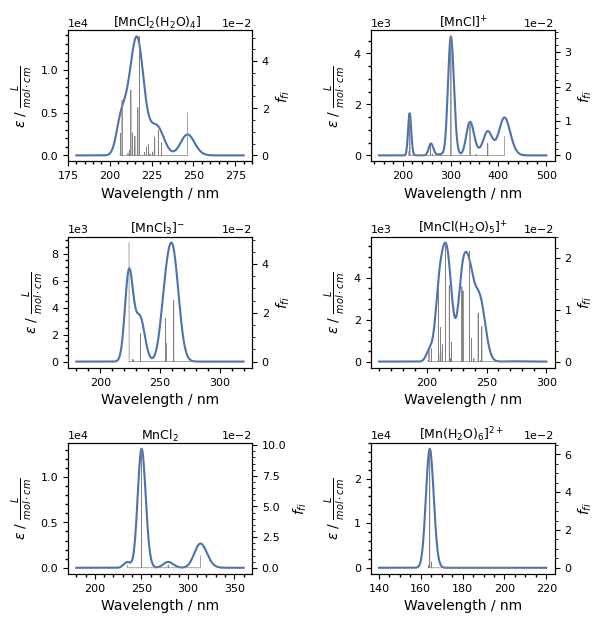

In [49]:
fig, axes = plt.subplots(3,2,figsize=(6.3,6.3))

make_subplots(axes[0][0], MnCl2aq_uvvis, 'X b3lyp6311++', 'Y b3lyp6311++', r'[MnCl$_{2}$(H$_{2}$O)$_{4}$]', MnCl2aq_peak_mod, 'X b3lyp6311++', 'Y b3lyp6311++', (4,4), (-2,-2), (0.79,0.91))
make_subplots(axes[0][1], uvvis, 'X MnCl+', 'Y MnCl+', r'[MnCl]$^{+}$', MnCl_peak_mod, 'X MnCl+', 'Y MnCl+', (3,3), (-2,-2), (0.7,0.91))
make_subplots(axes[1][0], uvvis, 'X MnCl3-', 'Y MnCl3-', r'[MnCl$_{3}$]$^{-}$', MnCl3_peak_mod, 'X MnCl3-', 'Y MnCl3-', (3,3), (-2,-2), (0.7,0.91))
make_subplots(axes[1][1], uvvis, 'X MnClH2O', 'Y MnClH2O', r'[MnCl(H$_{2}$O)$_{5}$]$^{+}$', MnClH2O_peak_mod, 'X MnClH2O', 'Y MnClH2O', (3,3), (-2,-2), (0.81,0.91))
make_subplots(axes[2][0], uvvis, 'X MnCl2', 'Y MnCl2', r'MnCl$_{2}$', MnCl2_peak_mod, 'X MnCl2', 'Y MnCl2', (4,4), (-2,-2), (0.66,0.91))
make_subplots(axes[2][1], uvvis, 'X MnH2O', 'Y MnH2O', r'[Mn(H$_{2}$O)$_{6}$]$^{2+}$', MnH2O_peak_mod, 'X MnH2O', 'Y MnH2O', (4,4), (-2,-2), (0.79,0.91))

fig.tight_layout(pad=1)
plt.savefig('species_wpeak.png', dpi=150)
plt.show()

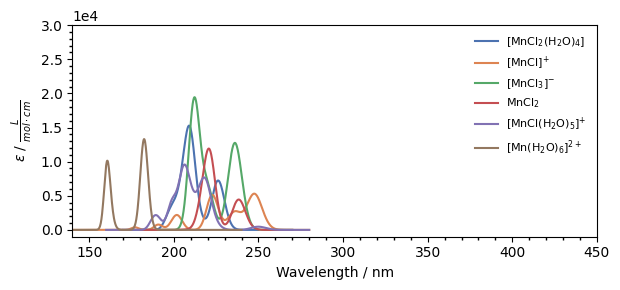

In [27]:
plt.figure(figsize=(6.3,3))
sns.set_palette("deep")
ax = sns.lineplot(data = MnCl2aq_uvvis_water, x = 'X b3lyp6311++', y = 'Y b3lyp6311++', label = r'[MnCl$_{2}$(H$_{2}$O)$_{4}$]') 
sns.lineplot(data = uvvis_water, x = 'X MnCl+', y = 'Y MnCl+', label = r'[MnCl]$^{+}$') 
sns.lineplot(data = uvvis_water, x = 'X MnCl3-', y = 'Y MnCl3-', label = r'[MnCl$_{3}$]$^{-}$') 
sns.lineplot(data = uvvis_water, x = 'X MnCl2', y = 'Y MnCl2', label = r'MnCl$_{2}$') 
sns.lineplot(data = uvvis_water, x = 'X MnClH2O', y = 'Y MnClH2O', label = r'[MnCl(H$_{2}$O)$_{5}$]$^{+}$') 
sns.lineplot(data = uvvis_water, x = 'X MnH2O', y = 'Y MnH2O', label = r'[Mn(H$_{2}$O)$_{6}$]$^{2+}$') 

ax.set_xlabel('Wavelength / nm')
ax.set_ylabel(r'$\epsilon$ / $\frac{L}{mol \cdot cm}$')
ax.set_ylim(-1000, 30000)
ax.set_xlim(140, 450)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True)
ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (4,4))

# handles, labels = ax.get_legend_handles_labels()
plt.legend(frameon = False, fontsize = 8)
# rcParams['legend.columnspacing']=1
plt.tight_layout()
plt.savefig('water_species_uvvis.png', dpi=150)
plt.show()

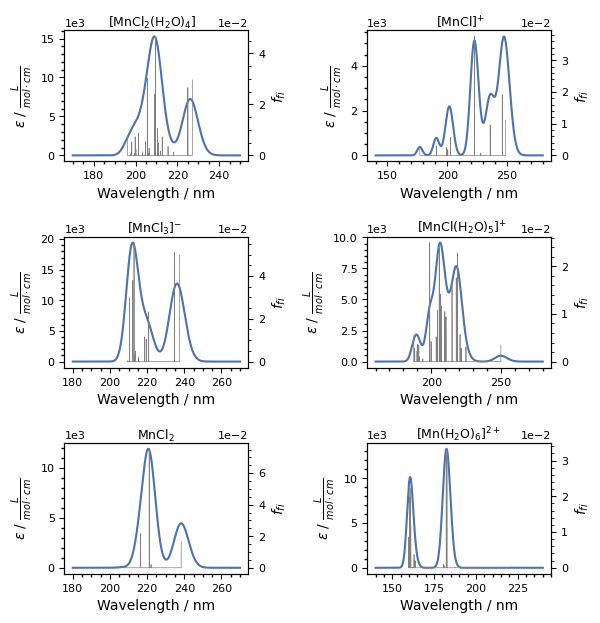

In [51]:
fig, axes = plt.subplots(3,2,figsize=(6.3,6.3))

make_subplots(axes[0][0], MnCl2aq_uvvis_water, 'X b3lyp6311++', 'Y b3lyp6311++', r'[MnCl$_{2}$(H$_{2}$O)$_{4}$]', MnCl2aq_water_peak_mod, 'X b3lyp6311++', 'Y b3lyp6311++', (3,3), (-2,-2), (0.78,0.91))
make_subplots(axes[0][1], uvvis_water, 'X MnCl+', 'Y MnCl+', r'[MnCl]$^{+}$', MnCl_water_peak_mod, 'X MnCl+', 'Y MnCl+', (3,3), (-2,-2), (0.7,0.91))
make_subplots(axes[1][0], uvvis_water, 'X MnCl3-', 'Y MnCl3-', r'[MnCl$_{3}$]$^{-}$', MnCl3_water_peak_mod, 'X MnCl3-', 'Y MnCl3-', (3,3), (-2,-2), (0.7,0.91))
make_subplots(axes[1][1], uvvis_water, 'X MnClH2O', 'Y MnClH2O', r'[MnCl(H$_{2}$O)$_{5}$]$^{+}$', MnClH2O_water_peak_mod, 'X MnClH2O', 'Y MnClH2O', (3,3), (-2,-2), (0.82,0.91))
make_subplots(axes[2][0], uvvis_water, 'X MnCl2', 'Y MnCl2', r'MnCl$_{2}$', MnCl2_water_peak_mod, 'X MnCl2', 'Y MnCl2', (3,3), (-2,-2), (0.66,0.91))
make_subplots(axes[2][1], uvvis_water, 'X MnH2O', 'Y MnH2O', r'[Mn(H$_{2}$O)$_{6}$]$^{2+}$', MnH2O_water_peak_mod, 'X MnH2O', 'Y MnH2O', (3,3), (-2,-2), (0.79,0.91))

fig.tight_layout(pad=1)
plt.savefig('water_species_wpeak.png', dpi=150)
plt.show()

In [52]:
def make_subplots_cross(axes, dataname, miny, maxy, scilimits, labels_list, ncol):
    ax = axes
    sns.lineplot(data = dataname, ax=ax, dashes=False)
    ax.set_ylabel(None, fontsize = 0)
    ax.set_xlabel(None, fontsize = 0)
    ax.set_xlim(200,600)
    ax.set_ylim(miny, maxy)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True, labelsize = 8)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)
    ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = scilimits)
    ax.yaxis.offsetText.set_fontsize(8)
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles = handles, labels = labels_list, frameon = False, ncol = ncol, fontsize = 8)

In [53]:
def make_subplots_calcross(axes, dataname, color, scilimits):
    ax = axes
    sns.lineplot(data = dataname, ax=ax, palette = color)
    ax.set_ylabel(None, fontsize = 0)
    ax.set_xlabel(None, fontsize = 0)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True, labelsize = 8)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)
    ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = scilimits)
    ax.yaxis.offsetText.set_fontsize(8)

In [54]:
labels_water = ['3.48 M', '1.77 M', '8.79$\cdot$10$^{-1}$ M', '4.19$\cdot$10$^{-1}$ M']
labels_hcl = ['3.08 M', '1.67 M', '8.31$\cdot$10$^{-1}$ M', '4.31$\cdot$10$^{-1}$ M', '2.20$\cdot$10$^{-1}$ M', '1.16$\cdot$10$^{-1}$ M', '5.76$\cdot$10$^{-2}$ M']
labels_ForRep = ['1.62 M in water', '1.63 M in HCl', '8.93$\cdot$10$^{-1}$ M in water', '8.76$\cdot$10$^{-1}$ M in HCl']
labels_wNaCl = ['2.90 M', '1.51 M', '1.00 M', '7.51$\cdot$10$^{-1}$ M', '5.85$\cdot$10$^{-1}$ M', '2.55$\cdot$10$^{-1}$ M', '1.27$\cdot$10$^{-1}$ M']
labels_cal = [r'[MnCl$_{2}$(H$_{2}$O)$_{4}$]', r'[MnCl]$^{+}$', r'[MnCl$_{3}$]$^{-}$', r'[MnCl(H$_{2}$O)$_{5}$]$^{+}$', r'MnCl$_{2}$', r'[Mn(H$_{2}$O)$_{6}$]$^{2+}$']

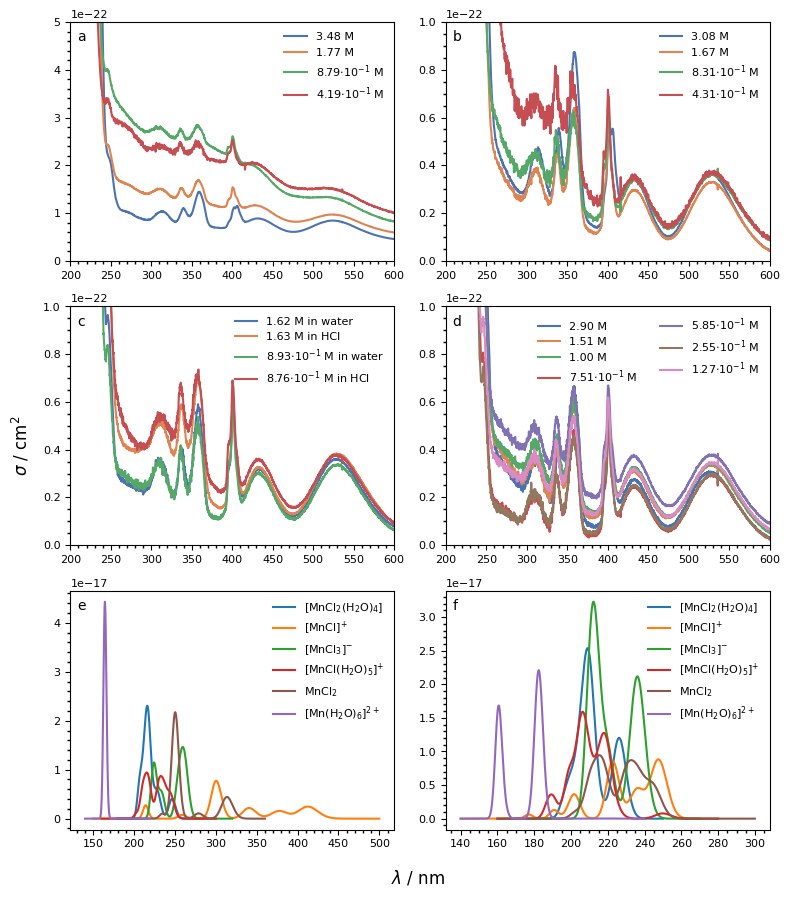

In [60]:
fig, axes = plt.subplots(3,2, figsize=(8,9))
sns.set_palette('deep')

make_subplots_cross(axes[0][0], in_water, 0, 5*10**(-22), (-22,-22), labels_water, 1)
make_subplots_cross(axes[0][1], in_hcl, 0, 1*10**(-22), (-22,-22), labels_hcl, 1)
make_subplots_cross(axes[1][0], ForRep, 0, 10**(-22), (-22,-22), labels_ForRep, 1)
make_subplots_cross(axes[1][1], wNaCl, 0, 10**(-22), (-22,-22), labels_wNaCl, 2)

make_subplots_calcross(axes[2][0], sigma_MnCl2wH2O, ['tab:blue'], (-17,-17))
make_subplots_calcross(axes[2][0], sigma_MnCl, ['tab:orange'], (-17,-17))
make_subplots_calcross(axes[2][0], sigma_MnCl3, ['tab:green'], (-17,-17))
make_subplots_calcross(axes[2][0], sigma_MnClH2O, ['tab:red'], (-17,-17))
make_subplots_calcross(axes[2][0], sigma_MnCl2, ['tab:brown'], (-17,-17))
make_subplots_calcross(axes[2][0], sigma_MnH2O, ['tab:purple'], (-17,-17))
handles, _ = axes[2][0].get_legend_handles_labels()
axes[2][0].legend(labels = labels_cal, handles = handles, frameon = False, ncol = 1, fontsize = 8)

make_subplots_calcross(axes[2][1], sigma_MnCl2wH2O_water, ["tab:blue"], (-17,-17))
make_subplots_calcross(axes[2][1], sigma_MnCl_water, ['tab:orange'], (-17,-17))
make_subplots_calcross(axes[2][1], sigma_MnCl3_water, ['tab:green'], (-17,-17))
make_subplots_calcross(axes[2][1], sigma_MnClH2O_water, ['tab:red'], (-17,-17))
make_subplots_calcross(axes[2][1], sigma_MnClH2O, ['tab:brown'], (-17,-17))
make_subplots_calcross(axes[2][1], sigma_MnH2O_water, ['tab:purple'], (-17,-17))
handles, _ = axes[2][1].get_legend_handles_labels()
axes[2][1].legend(labels = labels_cal, handles = handles, frameon = False, ncol = 1, fontsize = 8)

sublabels = ['a', 'b', 'c', 'd', 'e', 'f']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.supxlabel(r'         $\lambda$ / nm')
fig.supylabel(r'$\sigma$ / cm$^{2}$')

plt.tight_layout(pad=1)
plt.savefig('cross_sec_full.png', dpi=150)
plt.show()

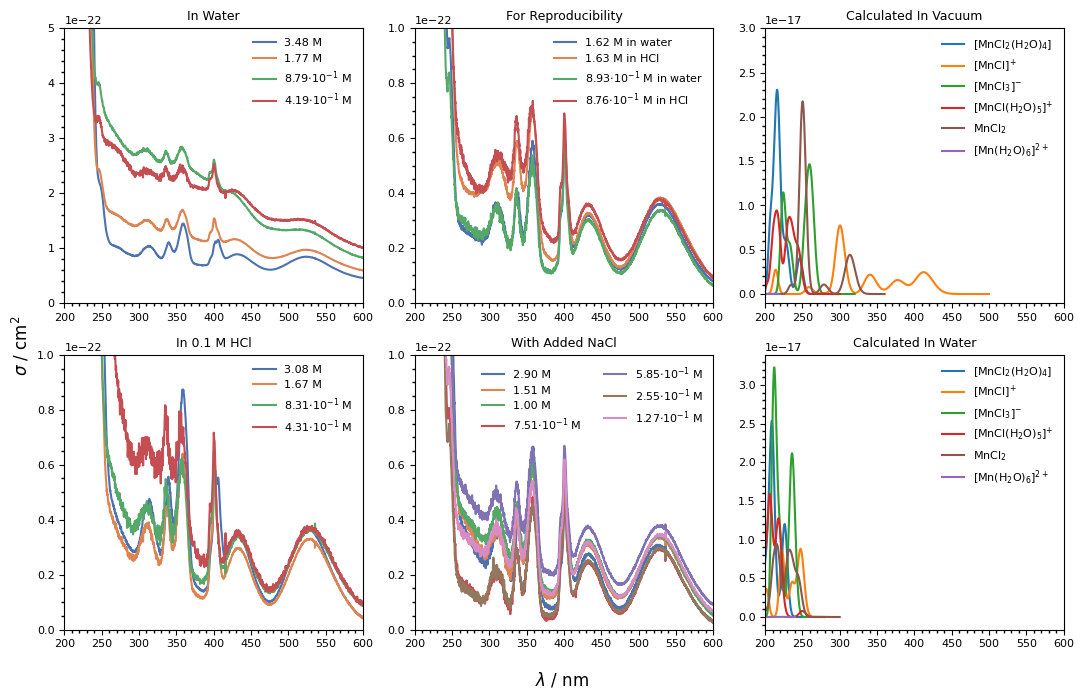

In [67]:
fig, axes = plt.subplots(2,3, figsize=(11,7))
sns.set_palette('deep')

make_subplots_cross(axes[0][0], in_water, 0, 5*10**(-22), (-22,-22), labels_water, 1)
axes[0][0].set_title('In Water', fontsize=9)
make_subplots_cross(axes[1][0], in_hcl, 0, 1*10**(-22), (-22,-22), labels_hcl, 1)
axes[1][0].set_title('In 0.1 M HCl', fontsize=9)
make_subplots_cross(axes[0][1], ForRep, 0, 10**(-22), (-22,-22), labels_ForRep, 1)
axes[0][1].set_title('For Reproducibility', fontsize=9)
make_subplots_cross(axes[1][1], wNaCl, 0, 10**(-22), (-22,-22), labels_wNaCl, 2)
axes[1][1].set_title('With Added NaCl', fontsize=9)

make_subplots_calcross(axes[0][2], sigma_MnCl2wH2O, ['tab:blue'], (-17,-17))
make_subplots_calcross(axes[0][2], sigma_MnCl, ['tab:orange'], (-17,-17))
make_subplots_calcross(axes[0][2], sigma_MnCl3, ['tab:green'], (-17,-17))
make_subplots_calcross(axes[0][2], sigma_MnClH2O, ['tab:red'], (-17,-17))
make_subplots_calcross(axes[0][2], sigma_MnCl2, ['tab:brown'], (-17,-17))
make_subplots_calcross(axes[0][2], sigma_MnH2O, ['tab:purple'], (-17,-17))
handles, _ = axes[0][2].get_legend_handles_labels()
axes[0][2].legend(labels = labels_cal, handles = handles, frameon = False, ncol = 1, fontsize = 8)
axes[0][2].set_xlim(200,600)
axes[0][2].set_ylim(-1*10**(-18),3*10**(-17))
axes[0][2].set_title('Calculated In Vacuum', fontsize=9)

make_subplots_calcross(axes[1][2], sigma_MnCl2wH2O_water, ["tab:blue"], (-17,-17))
make_subplots_calcross(axes[1][2], sigma_MnCl_water, ['tab:orange'], (-17,-17))
make_subplots_calcross(axes[1][2], sigma_MnCl3_water, ['tab:green'], (-17,-17))
make_subplots_calcross(axes[1][2], sigma_MnClH2O_water, ['tab:red'], (-17,-17))
make_subplots_calcross(axes[1][2], sigma_MnClH2O, ['tab:brown'], (-17,-17))
make_subplots_calcross(axes[1][2], sigma_MnH2O_water, ['tab:purple'], (-17,-17))
handles, _ = axes[1][2].get_legend_handles_labels()
axes[1][2].legend(labels = labels_cal, handles = handles, frameon = False, ncol = 1, fontsize = 8)
axes[1][2].set_xlim(200,600)
axes[1][2].set_title('Calculated In Water', fontsize=9)

# sublabels = ['a', 'b', 'c', 'd', 'e', 'f']
# for ax, l in zip(axes.flatten(), sublabels):
#     ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.supxlabel(r'         $\lambda$ / nm')
fig.supylabel(r'$\sigma$ / cm$^{2}$')

plt.tight_layout(pad=1)
plt.savefig('crosssec_for_defence.png', dpi=150)
plt.show()

In [229]:
def make_subplots_rate(axes, dataname, color, scilimits):
    ax = axes
    sns.lineplot(data = dataname, ax=ax, palette = color, label = None)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True, labelsize = 8)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)
    ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = scilimits)
    ax.yaxis.offsetText.set_fontsize(8)

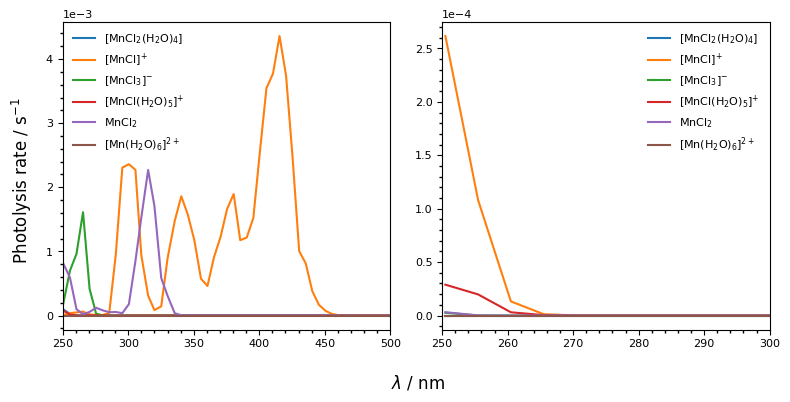

In [237]:
fig, axes = plt.subplots(1,2,figsize = (8, 4))

make_subplots_rate(axes[0], jMnCl2wH2O, ['tab:blue'], (-3,-3))
make_subplots_rate(axes[0], jMnCl, ['tab:orange'], (-3,-3))
make_subplots_rate(axes[0], jMnCl3, ['tab:green'], (-3,-3))
make_subplots_rate(axes[0], jMnClH2O, ['tab:red'], (-3,-3))
make_subplots_rate(axes[0], jMnCl2, ['tab:purple'], (-3,-3))
make_subplots_rate(axes[0], jMnH2O, ['tab:brown'], (-3,-3))

make_subplots_rate(axes[1], jMnCl2wH2O_water, ['tab:blue'], (-4,-4))
make_subplots_rate(axes[1], jMnCl_water, ['tab:orange'], (-4,-4))
make_subplots_rate(axes[1], jMnCl3_water, ['tab:green'], (-4,-4))
make_subplots_rate(axes[1], jMnClH2O_water, ['tab:red'], (-4,-4))
make_subplots_rate(axes[1], jMnCl2_water, ['tab:purple'], (-4,-4))
make_subplots_rate(axes[1], jMnH2O_water, ['tab:brown'], (-4,-4))

fig.supxlabel(r'         $\lambda$ / nm')
fig.supylabel(r'      Photolysis rate / s$^{-1}$')
handles, _ = axes[0].get_legend_handles_labels()
axes[0].legend(labels = labels_cal, handles = handles, frameon = False, ncol = 1, fontsize = 8)
handles, _ = axes[1].get_legend_handles_labels()
axes[1].legend(labels = labels_cal, handles = handles, frameon = False, ncol = 1, fontsize = 8)
axes[0].set_xlim(250, 500)
axes[1].set_xlim(250, 300)
fig.tight_layout(pad=1)
plt.savefig('photolysisrate.png', dpi=150)
plt.show()

In [215]:
labels_rate = [r'NO$_{2}$', r'1.62 M MnCl$_{2}\cdot$4H$_{2}$O in water', r'1.63 M MnCl$_{2}\cdot$4H$_{2}$O in diluted HCl']

In [234]:
def make_subplots_rateno2(axes, dataname, xdataname, ydataname, color, scilimits):
    ax = axes
    sns.lineplot(data = dataname, x = xdataname, y = ydataname, ax=ax, palette = color, label=None)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True, labelsize = 8)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)
    ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = scilimits)
    ax.yaxis.offsetText.set_fontsize(8)

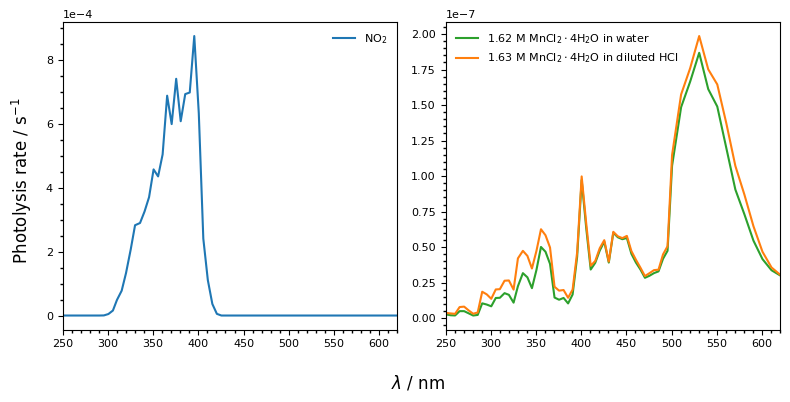

In [248]:
fig, axes = plt.subplots(1,2,figsize = (8, 4))

make_subplots_rate(axes[0], no2_rate, ['tab:blue'], (-4,-4))

make_subplots_rate(axes[1], j1, ['tab:green'], (-7,-7))
make_subplots_rate(axes[1], j2, ['tab:orange'], (-7,-7))

fig.supxlabel(r'         $\lambda$ / nm')
fig.supylabel(r'      Photolysis rate / s$^{-1}$')
handles, _ = axes[0].get_legend_handles_labels()
axes[0].legend(labels = [r'NO$_{2}$'], handles = handles, frameon = False, ncol = 1, fontsize = 8)
handles, _ = axes[1].get_legend_handles_labels()
axes[1].legend(labels = labels_rate[1:], handles = handles, frameon = False, ncol = 1, fontsize = 8)
axes[0].set_xlim(250, 620)
axes[1].set_xlim(250, 620)
fig.tight_layout(pad=1)
plt.savefig('no2_vs_ex.png', dpi=150)
plt.show()

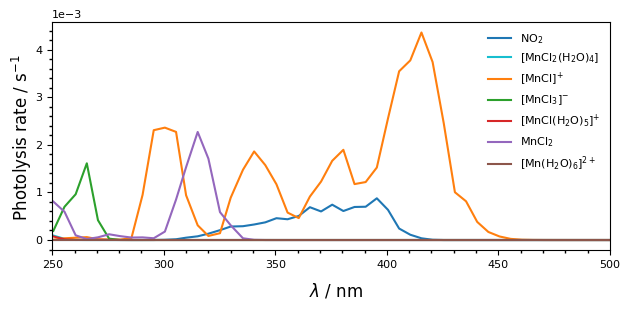

In [249]:
fig, axes = plt.subplots(1,1,figsize = (6.3, 3))

make_subplots_rate(axes, no2_rate, ['tab:blue'], (-3,-3))
make_subplots_rate(axes, jMnCl2wH2O, ['tab:cyan'], (-3,-3))
make_subplots_rate(axes, jMnCl, ['tab:orange'], (-3,-3))
make_subplots_rate(axes, jMnCl3, ['tab:green'], (-3,-3))
make_subplots_rate(axes, jMnClH2O, ['tab:red'], (-3,-3))
make_subplots_rate(axes, jMnCl2, ['tab:purple'], (-3,-3))
make_subplots_rate(axes, jMnH2O, ['tab:brown'], (-3,-3))

# make_subplots_rate(axes[1], j1, ['tab:blue'], labels_cal[0], (-7,-7))
# make_subplots_rate(axes[1], j2, ['tab:orange'], labels_cal[1], (-7,-7))

fig.supxlabel(r'         $\lambda$ / nm')
fig.supylabel(r'      Photolysis rate / s$^{-1}$')
handles, _ = axes.get_legend_handles_labels()
axes.legend(labels = [r'NO$_{2}$', r'[MnCl$_{2}$(H$_{2}$O)$_{4}$]', r'[MnCl]$^{+}$', r'[MnCl$_{3}$]$^{-}$', r'[MnCl(H$_{2}$O)$_{5}$]$^{+}$', r'MnCl$_{2}$', r'[Mn(H$_{2}$O)$_{6}$]$^{2+}$'], handles = handles, frameon = False, ncol = 1, fontsize = 8)
# handles, _ = axes[1].get_legend_handles_labels()
# axes[1].legend(labels = labels_rate[1:], handles = handles, frameon = False, ncol = 1, fontsize = 8)
axes.set_xlim(250, 500)
# axes[1].set_xlim(250, 620)
fig.tight_layout(pad=0.5)
plt.savefig('no2_vs_calvacuum', dpi=150)
plt.show()